---
## Technical Report Notebook 4
---
### Modelling Extension - Hailstorm Severity + Earthquake Classification Investigations

This notebook extends the tweet investigations into two different classificiation exercises, to answer the following questions:

    1. Can tweets predict hail events of differing magnitude? (Severity!)
    2. Can tweets predict other types of natural catastrophes?
    
---

### 1. Hail Severity Test

Now we know that tweets can predict hail using a classification algorithm moderately well, a secondary investigation into _event severity_ will be conducted. The purpose of this is to investigate whether the language used in the more severe Brisbane (2014) event is different to Sydney (2015).

To do this I will adjust the classification exercise using the event ID's as classes:

- Brisbane Hail (Cat_ID - 144):   **1**
- Sydney Hail (Cat_ID - 154):   **0**

In [1]:
# Import modelling libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Import tweet data
tweet_text = pd.read_csv("./hail_tweet_text.csv")
# Drop Index column
tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
# Create Brisbane and Sydney Event classes to test severity

# Create subset dataframe for hail-only tweets
hail_tweet_text = tweet_text.ix[tweet_text['hail'] > 0]                            

# Create new target variable
hail_tweet_text['event_class'] = 0

# Set Brisbane event to 1
hail_tweet_text.ix[hail_tweet_text['Cat_ID'] == 144, 'event_class'] = 1

# Check shape of new dataset
print(hail_tweet_text.shape)

# Set event class as y-predictor
y_hail = hail_tweet_text['event_class']

(4786, 1028)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


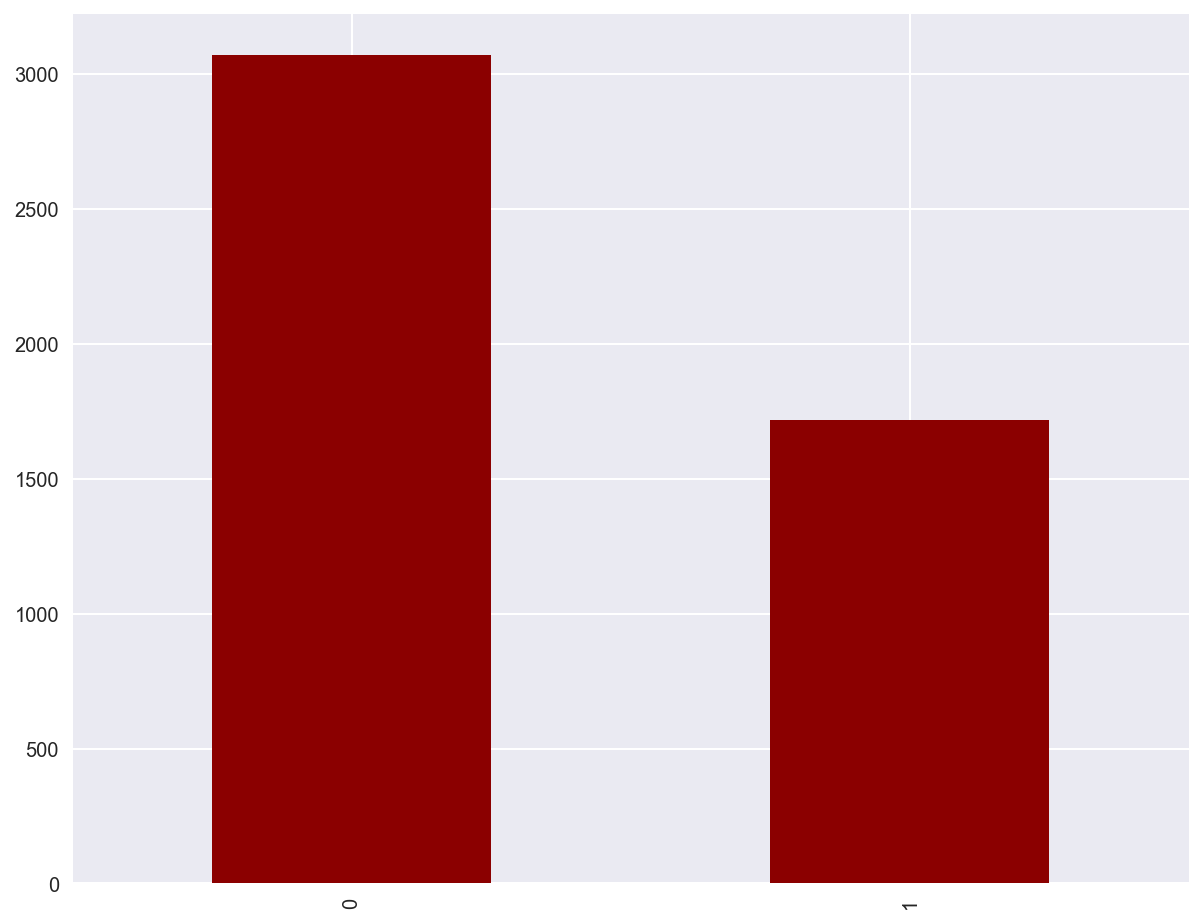

In [4]:
# Plot class counts of Brisbane (1) vs. Sydney (0)

hail_tweet_text['event_class'].value_counts().plot(figsize=(10,8),kind='bar',color='darkred')

In [5]:
# Create Severity modelling dataframe:

# Remove twitter user data
X_hail_tweets = hail_tweet_text.ix[:,26:]
print (X_hail_tweets.shape)

# Drop columns from dataframe relating to hail, location and event to create predictors
X_hail_tweets.drop(X_hail_tweets[['hail','hailstorm','event_class','australia','bnestorm','queensland','sydney',
                                  'sydneystorm','brisbane','brisbanestorm']], axis=1, inplace=True)
print (X_hail_tweets.shape)

(4786, 1002)
(4786, 992)


### _Random Forest Classification_

In [6]:
# transform our predictors
tf_transformer = TfidfTransformer(use_idf=False).fit(X_hail_tweets)
X_hail = tf_transformer.transform(X_hail_tweets)

# create train/test (0.8 split found to give fairly good performance)
X_train_hail, X_test_hail, y_train_hail, y_test_hail = train_test_split(X_hail_tweets, y_hail, test_size=0.8)

# set up RFC model with hyperparameters from hail model evaluation:
rfc_hail = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_hail.fit(X_train_hail, y_train_hail)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [7]:
# Extract the top features from the decision tree classifier.

top_features_rfc_hail = pd.DataFrame({
        'feature':X_hail_tweets.columns,
        'importance':rfc_hail.feature_importances_})

top_features_rfc_hail.sort_values('importance', ascending=False, inplace=True)
top_features_rfc_hail.head(20)

,feature,importance
139,chaos,0.061038
504,massive,0.056136
991,sentiment,0.050304
819,super,0.037503
798,storm,0.037392
129,causes,0.027970
758,slammed,0.027243
732,seen,0.014700
973,worst,0.014683
177,cut,0.014114


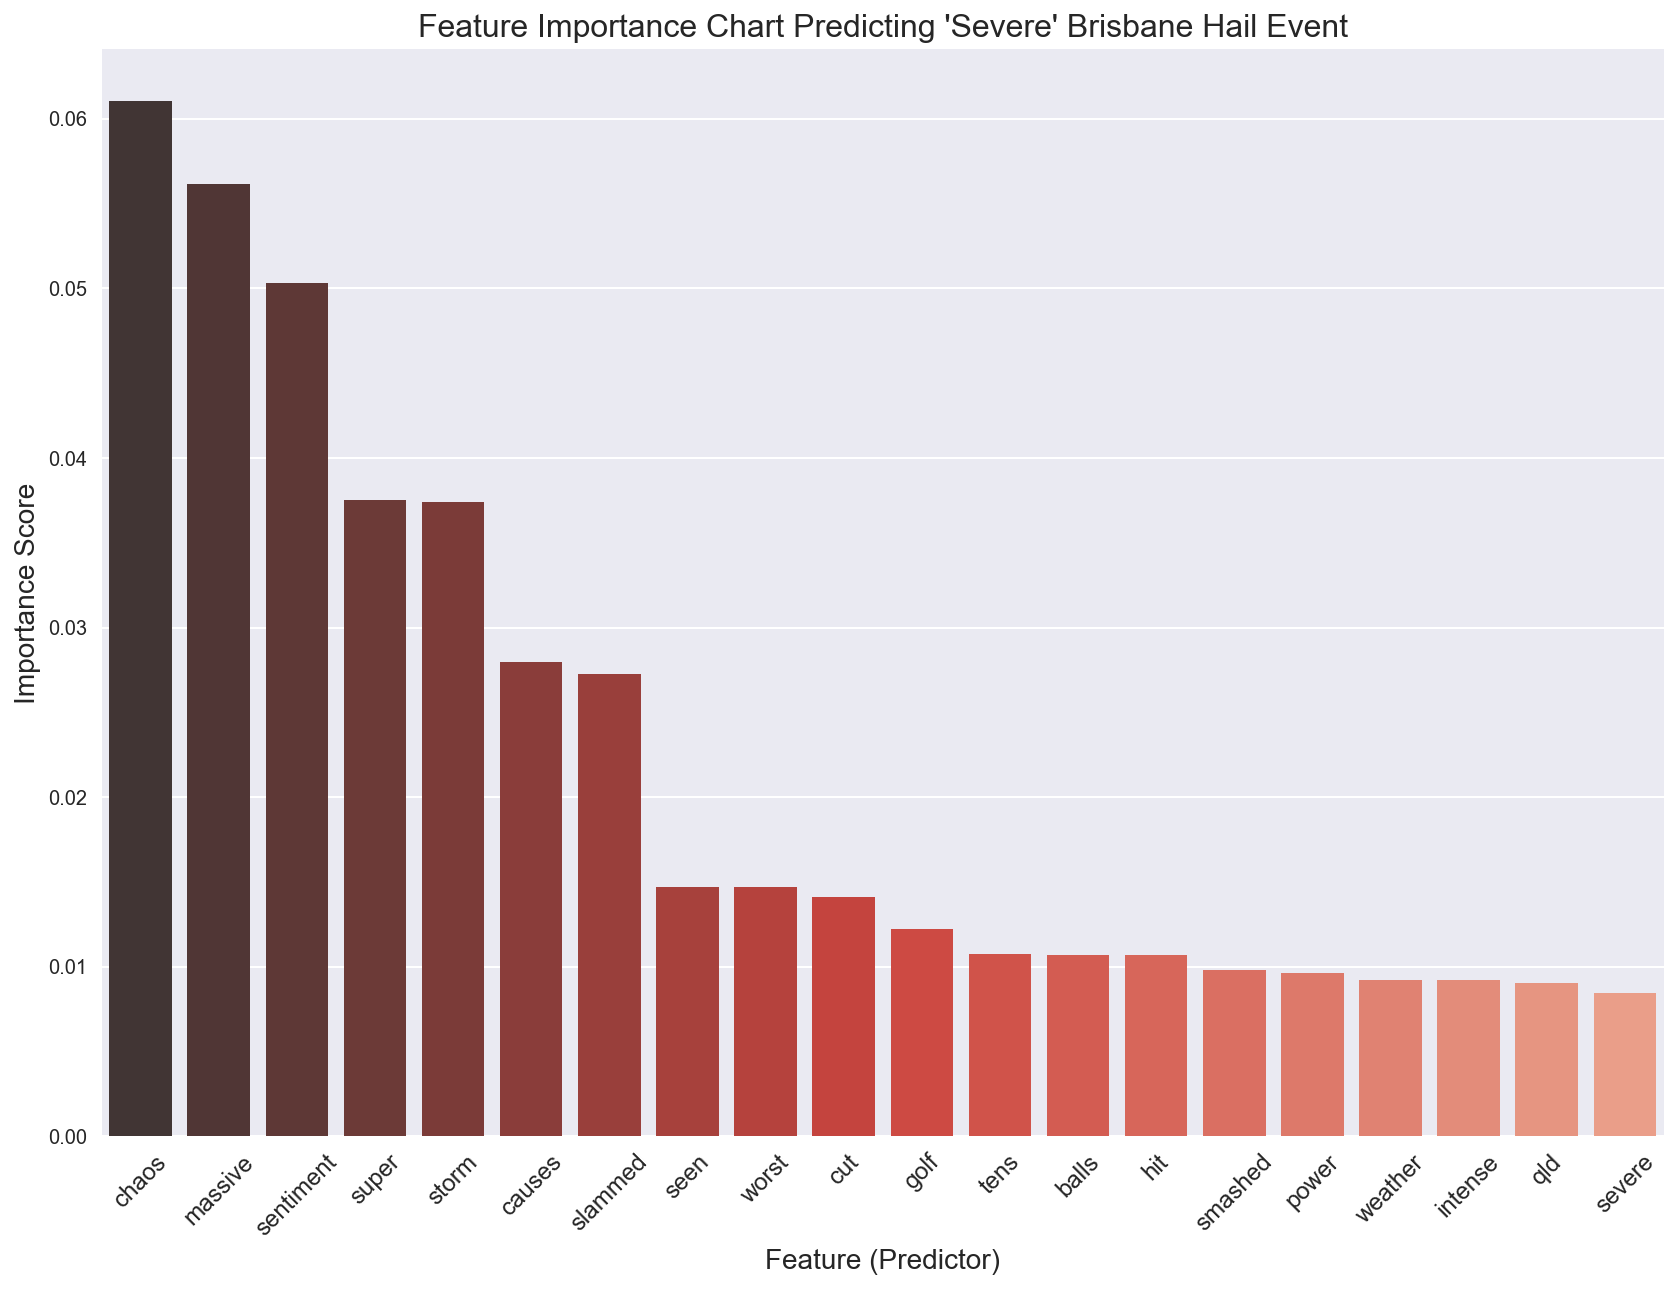

In [8]:
# "Hail"term frequency distribution plot over time

plt.figure(figsize=(14,10))
plt.title("Feature Importance Chart Predicting 'Severe' Brisbane Hail Event" ,size=16)
ax = sns.barplot(x='feature', y='importance', data=top_features_rfc_hail.head(20),ci=None,palette="Reds_d")
plt.xlabel('Feature (Predictor)',size=14)
plt.setp(ax.get_xticklabels(), rotation=45,size=12)
plt.ylabel('Importance Score',size=14)

In [9]:
rfc_hail_scores = cross_val_score(rfc_hail, X_test_hail, y_test_hail, cv=5)

print (rfc_hail_scores)
print (sum(rfc_hail_scores)/len(rfc_hail_scores))

# Create predicted y values

yhat_test_rfc_hail = rfc_hail.predict(X_test_hail)
yhat_test_rfc_hail_pp = rfc_hail.predict_proba(X_test_hail)

# convert the predicted and actual values to a confusion array

confusion_array_rfc = confusion_matrix(y_test_hail, yhat_test_rfc_hail, labels=[1,0])

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['severe','moderate'],
                         columns=['pred_severe','pred_moderate'])

print ("confusion matrix")
print (confusion_rfc)
print ("--------")
print ("accuracy:", accuracy_score(y_test_hail, yhat_test_rfc_hail)) # accuracy = (tp + tn) / total_population)
print ("--------")
print (classification_report(y_test_hail, yhat_test_rfc_hail))

[ 0.81747066  0.8381201   0.80939948  0.79869281  0.83137255]
0.81901112133
confusion matrix
          pred_severe  pred_moderate
severe            826            532
moderate          179           2292
--------
accuracy: 0.814311830765
--------
             precision    recall  f1-score   support

          0       0.81      0.93      0.87      2471
          1       0.82      0.61      0.70      1358

avg / total       0.82      0.81      0.81      3829



#### Hail Severity Summary

The hail severiy classification provides positive results.

- Whilst the accuracy score is lower than those in the hail prediction modelling, it is still high at 0.82.
- The true positive prediction (known severe hail tweets) of the test set is respectable, with high precision and recall. This results in an overall f1 score of 0.81.
- The most important features that predict the 'severe' class are also consistent with terms we would usually associate with damaging hail events: ***chaos, super, massive.***

Overall this investigation provides an encouraging preliminary result and confidence that the tweet text can predict hail severity.

---

### 2. Earthquake Classification Investigation

In the tweet EDA we identified another type of natural catastrophe - an earthquake event in Nepal. The economic loss of this event is estimated to be in excess of USD 6 billion.

The serendipitous identification of another type of catastrophe in this study has framed a third investigation - can our optimal hail algorithm also effectively identify tweets of a second type of catastrophe?

Firstly I will create a new class target using 'hail' and 'earthquake' text from our data previously prepared for modelling...

In [10]:
# Read in data:

hail_tweet_text = pd.read_csv("./hail_tweet_text.csv")
hail_tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

Setting up the classification exercise with earthquake and hail classes (0 - no catastrophe; 1-hail; 2-earthquake)

In [11]:
# Create hail and earthquake classes

hail_tweet_text['catastrophe_class'] = 0

hail_tweet_text.ix[hail_tweet_text['hail'] >= 1, 'catastrophe_class'] = 1
hail_tweet_text.ix[hail_tweet_text['hailstorm'] >= 1, 'catastrophe_class'] = 1

hail_tweet_text.ix[hail_tweet_text['earthquake'] >= 1, 'catastrophe_class'] = 2
hail_tweet_text.ix[hail_tweet_text['quake'] >= 1, 'catastrophe_class'] = 2

y_total = hail_tweet_text['catastrophe_class']

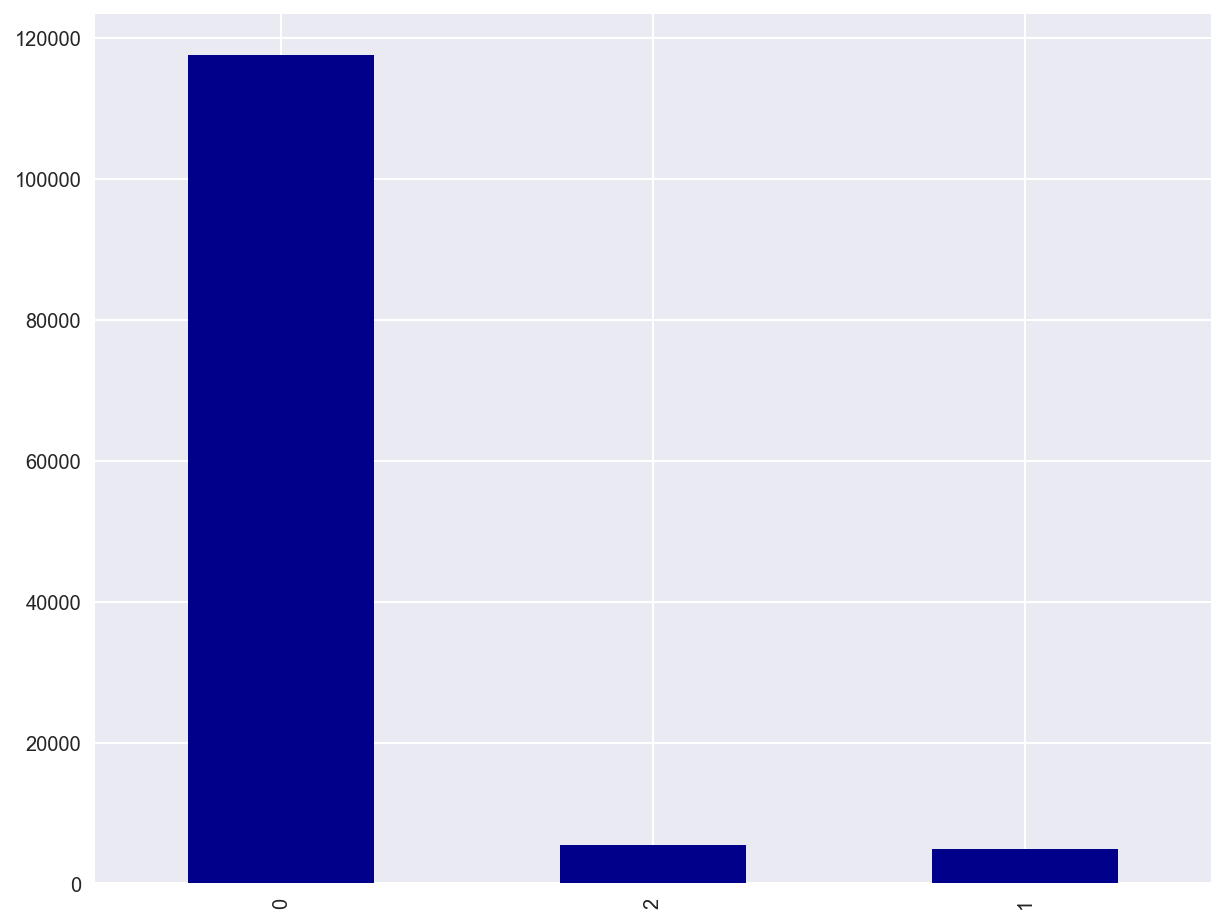

In [12]:
# Plot out earthquake, hail and 0 classes

hail_tweet_text['catastrophe_class'].value_counts().plot(figsize=(10,8),kind='bar',color='darkblue')

In [13]:
# Create predictors

htt_total = hail_tweet_text.ix[:,26:]
print (htt_total.shape)

htt_total.drop(htt_total[['hail','hailstorm','earthquake','quake',
                          'australia','bnestorm','queensland','sydney',
                          'sydneystorm','brisbane','brisbanestorm','nepal','kathmandu','india',
                          'catastrophe_class']], axis=1, inplace=True)
print (htt_total.shape)

(127989, 1002)
(127989, 987)


### _Random Forest Classification_

I will now use the optimised algorithm from the hail modelling to see how well it performs with another catastrophe class.

In [14]:
# Transform a count matrix to a normalized tf or tf-idf representation
tf_transformer = TfidfTransformer(use_idf=False).fit(htt_total)
X_total_tf = tf_transformer.transform(htt_total)

In [15]:
# Create Train/Test data
X_train, X_test, y_train, y_test = train_test_split(X_total_tf, y_total, test_size=0.8)

# Set RFC with parameters indentified in gridsearching from hail idenification modelling
rfc_total = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rfc_total.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [16]:
# Evaluate scores of RFC test set
rfc_scores = cross_val_score(rfc_total, X_test, y_test, cv=5)

print (rfc_scores)
print (sum(rfc_scores)/len(rfc_scores))

[ 0.95966797  0.95556424  0.9574198   0.95741564  0.95853885]
0.957721297339


In [17]:
top_features_rfc_eq = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_total.feature_importances_})

top_features_rfc_eq.sort_values('importance', ascending=False, inplace=True)
top_features_rfc_eq.head(10)

,feature,importance
490,magnitude,0.063181
986,sentiment,0.047089
182,damage,0.045137
368,hits,0.035090
793,storm,0.028525
130,causing,0.025620
394,injuries,0.022424
501,massive,0.017102
802,strong,0.014236
682,reported,0.013517


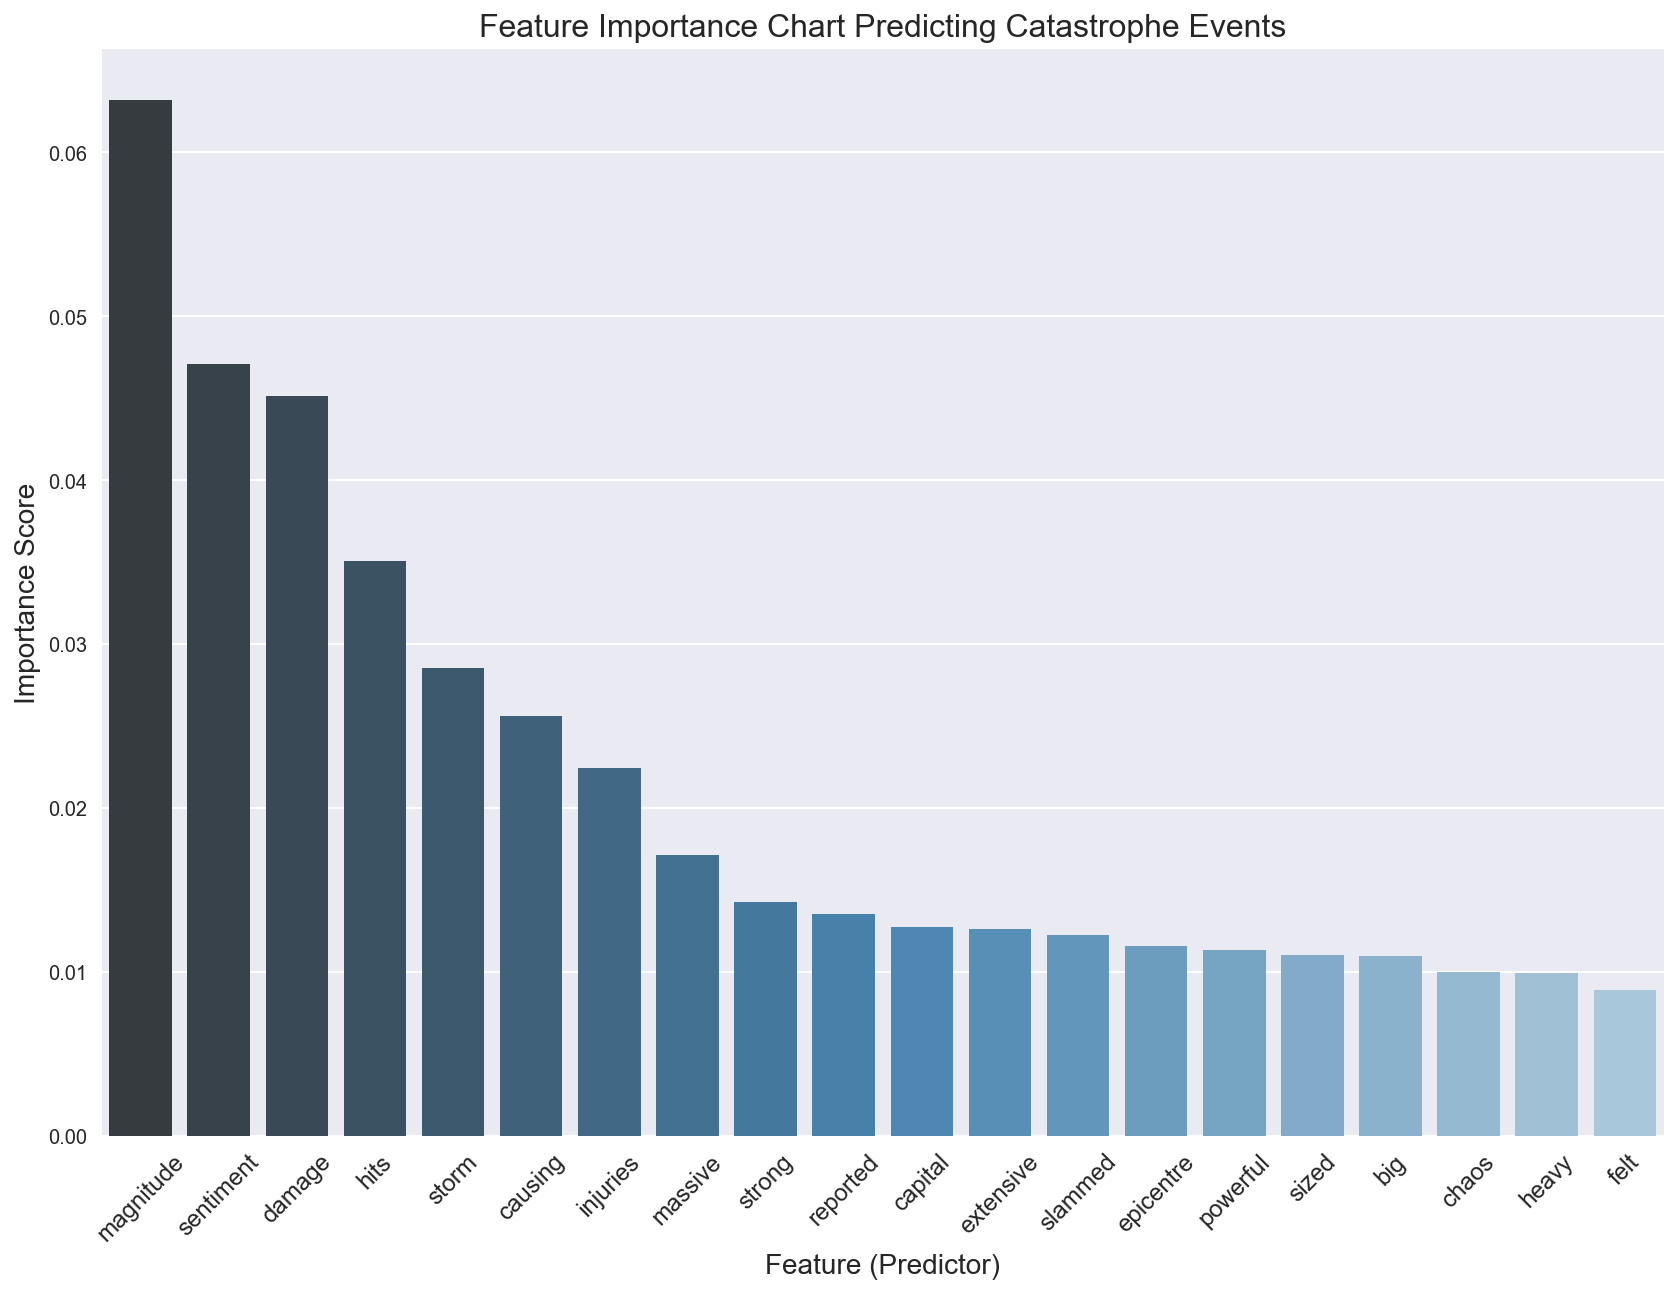

In [18]:
# "Hail"term frequency distribution plot over time

plt.figure(figsize=(14,10))
plt.title("Feature Importance Chart Predicting Catastrophe Events" ,size=16)
ax = sns.barplot(x='feature', y='importance', data=top_features_rfc_eq.head(20),ci=None,palette="Blues_d")
plt.xlabel('Feature (Predictor)',size=14)
plt.setp(ax.get_xticklabels(), rotation=45,size=12)
plt.ylabel('Importance Score',size=14)

In [19]:
# Create predicted y values

yhat_test_rfc = rfc_total.predict(X_test)
yhat_test_rfc_pp = rfc_total.predict_proba(X_test)

# convert the predicted and actual values to a confusion array

confusion_array_rfc = confusion_matrix(y_test, yhat_test_rfc, labels=[2,1,0])

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['eq', 'hail','no catastrophe'],
                         columns=['pred_eq','pred_hail', 'pred_no catastrophe'])
confusion_rfc

,pred_eq,pred_hail,pred_no catastrophe
eq,3095,3,1280
hail,1,1241,2704
no catastrophe,374,368,93326


In [20]:
print (classification_report(y_test, yhat_test_rfc))

             precision    recall  f1-score   support

          0       0.96      0.99      0.98     94068
          1       0.77      0.31      0.45      3946
          2       0.89      0.71      0.79      4378

avg / total       0.95      0.95      0.95    102392



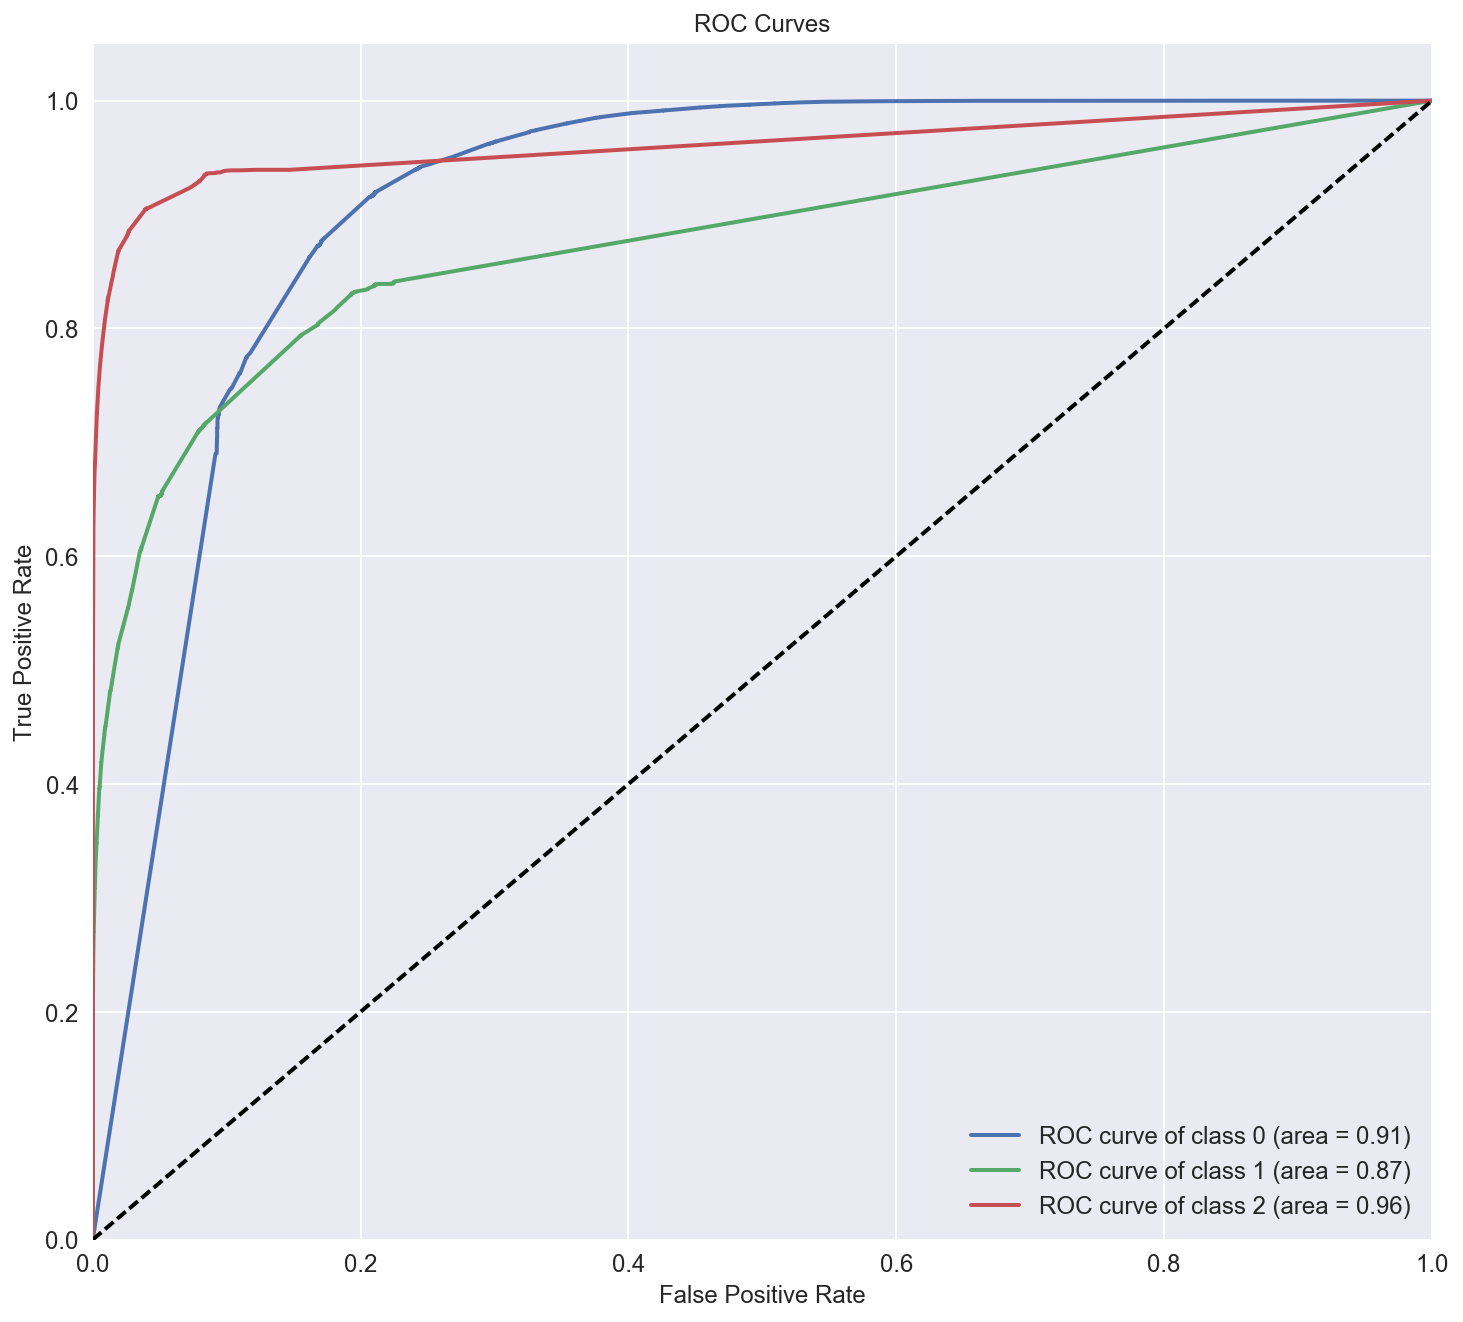

In [21]:
# Plot ROC Curve for all three classes
from scikitplot import classifier_factory

classifier_factory(rfc_total)
rfc_total.plot_roc_curve(X_test, y_test, random_state=1,text_fontsize='large',figsize=(12,11),curves='each_class')
plt.show()

#### Earthquake Classification Summary

The addition of earthquake as a third class in our model has produced interesting results. Overall the accuracy score of the classification is very high at 0.958.

When trained with 80% of the full dataset, the algorithm's ability to predict each class in the test data is different. As depicted by the ROC curve, the number of true positives (and the precision and recall) for the earthquake class is much higher than hail. 

The model is very good at classifying the _type of catastrophe_ when in fact it is a catastrophe (i.e.: predicting low predicted earthquakes when it is true hail, and vise versa), but in general, when introducing the earthquake class it performs less well than the hail-only modelling. This could be improved with adjusting the hyperparameters of the model and investigating other algorithms.

---

**CodeEnd :)** _This concludes the technical component of the project._

I will now discuss the investigation, results and successes in a final report...

### Link to [Notebook 5 - Report](capstone_technical_report_5_written_report.ipynb)

----